Food-101 Model Training
----------------------
This notebook trains a MobileNetV3 model on the Food-101 dataset.


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime

# Create necessary directories
os.makedirs("../models", exist_ok=True)

# Load label mappings
with open('food101_label_mappings.json', 'r') as f:
    mappings = json.load(f)
    label_to_index = mappings['label_to_index']
    index_to_label = {int(k): v for k, v in mappings['index_to_label'].items()}

# Number of classes
num_classes = len(label_to_index)
print(f"Training model for {num_classes} food classes")

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

Training model for 101 food classes


In [12]:
# Try loading saved datasets
try:
    print("Loading saved datasets...")
    train_dataset = tf.data.Dataset.load("../tf_datasets/food101_train")
    test_dataset = tf.data.Dataset.load("../tf_datasets/food101_test")
    print("Datasets loaded successfully!")
except Exception as e:
    print(f"Error loading datasets: {e}")
    print("Regenerating datasets from original data...")
    
    # Load original dataframe
    food101_df = pd.read_pickle("food101_df.pkl")
    train_df = food101_df[food101_df['split'] == 'train']
    test_df = food101_df[food101_df['split'] == 'test']
    
    # Function to preprocess image
    def preprocess_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.float32) / 255.0
        return image
    
    # Function to augment images
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image, label
    
    # Create datasets
    def create_dataset(df, augment_data=False):
        image_paths = tf.convert_to_tensor(df['image_path'].values)
        labels = tf.convert_to_tensor([label_to_index[label] for label in df['label'].values])
        
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
        dataset = dataset.map(lambda x, y: (preprocess_image(x), y), 
                             num_parallel_calls=AUTOTUNE)
        
        if augment_data:
            dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
        
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(AUTOTUNE)
        return dataset
    
    train_dataset = create_dataset(train_df, augment_data=True)
    test_dataset = create_dataset(test_df, augment_data=False)
    
    print("Datasets regenerated successfully!")


Loading saved datasets...
Datasets loaded successfully!


In [13]:
# Define model
def create_model():
    """Create MobileNetV3Small model for food recognition"""
    # Base model - MobileNetV3Small
    base_model = MobileNetV3Small(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        minimalistic=False
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

In [14]:
# Create model
model, base_model = create_model()
print("Model created successfully")

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model created successfully


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,286,357 (4.91 MB)

 Trainable params: 347,237 (1.32 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [15]:
# Setup callbacks
checkpoint = ModelCheckpoint(
    '../models/food101_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [16]:
# PHASE 1: Training with frozen base model
print("\nPHASE 1: Training with frozen base model...")
history = model.fit(
    train_dataset,
    epochs=10,  # Start with fewer epochs
    validation_data=test_dataset,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


PHASE 1: Training with frozen base model...
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3610 - loss: 8.1503
Epoch 1: val_accuracy improved from -inf to 0.00990, saving model to models/food101_best_model.h5


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 370s 154ms/step - accuracy: 0.3610 - loss: 8.1515 - val_accuracy: 0.0099 - val_loss: 23.6941 - learning_rate: 0.0010
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3111 - loss: 13.0138
Epoch 2: val_accuracy did not improve from 0.00990
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 347s 146ms/step - accuracy: 0.3111 - loss: 13.0137 - val_accuracy: 0.0099 - val_loss: 23.5428 - learning_rate: 0.0010
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3120 - loss: 13.2445
Epoch 3: val_accuracy did not improve from 0.00990
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 347s 146ms/step - accuracy: 0.3120 - loss: 13.2444 - val_accuracy: 0.0099 - val_loss: 23.2540 - learning_rate: 0.0010
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3153 - loss: 13.1909
Epoch 4: val_accuracy did not improve from 0.00990
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 348s 147ms/step - accuracy: 0.3153 - loss: 13.1908 - val_accuracy: 0.0099 - val_loss: 23.8882 - l

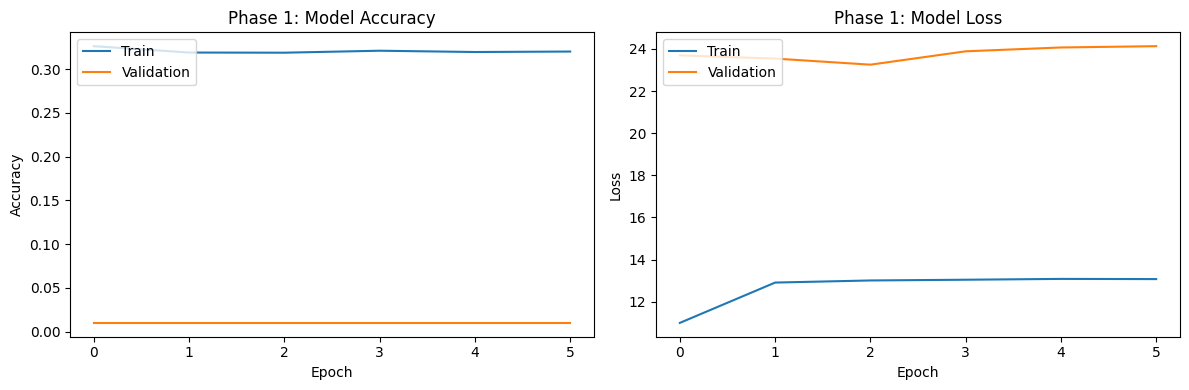

In [17]:
# Plot Phase 1 results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Phase 1: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Phase 1: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
# PHASE 2: Fine-tuning - unfreeze some layers
print("\nPHASE 2: Fine-tuning model...")
# Unfreeze the last few layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=15,
    validation_data=test_dataset,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


PHASE 2: Fine-tuning model...
Epoch 1/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0560 - loss: 4.5698
Epoch 1: val_accuracy did not improve from 0.00990
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 418s 172ms/step - accuracy: 0.0560 - loss: 4.5699 - val_accuracy: 0.0099 - val_loss: 6.6254 - learning_rate: 1.0000e-05
Epoch 2/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.0179 - loss: 4.6273
Epoch 2: val_accuracy improved from 0.00990 to 0.01002, saving model to models/food101_best_model.h5


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 214s 90ms/step - accuracy: 0.0179 - loss: 4.6273 - val_accuracy: 0.0100 - val_loss: 4.8835 - learning_rate: 1.0000e-05
Epoch 3/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0128 - loss: 4.7568
Epoch 3: val_accuracy did not improve from 0.01002
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 235s 99ms/step - accuracy: 0.0128 - loss: 4.7567 - val_accuracy: 0.0099 - val_loss: 5.0450 - learning_rate: 1.0000e-05
Epoch 4/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0106 - loss: 4.8255
Epoch 4: val_accuracy improved from 0.01002 to 0.01366, saving model to models/food101_best_model.h5


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 242s 102ms/step - accuracy: 0.0106 - loss: 4.8253 - val_accuracy: 0.0137 - val_loss: 4.7342 - learning_rate: 1.0000e-05
Epoch 5/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0198 - loss: 4.7483
Epoch 5: val_accuracy did not improve from 0.01366
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 254s 107ms/step - accuracy: 0.0198 - loss: 4.7482 - val_accuracy: 0.0099 - val_loss: 5.1490 - learning_rate: 1.0000e-05
Epoch 6/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.0075 - loss: 4.7216
Epoch 6: val_accuracy did not improve from 0.01366
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 252s 106ms/step - accuracy: 0.0076 - loss: 4.7214 - val_accuracy: 0.0099 - val_loss: 5.1871 - learning_rate: 1.0000e-05
Epoch 7/15
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0091 - loss: 4.7908
Epoch 7: val_accuracy did not improve from 0.01366

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 255s 108ms/step - 

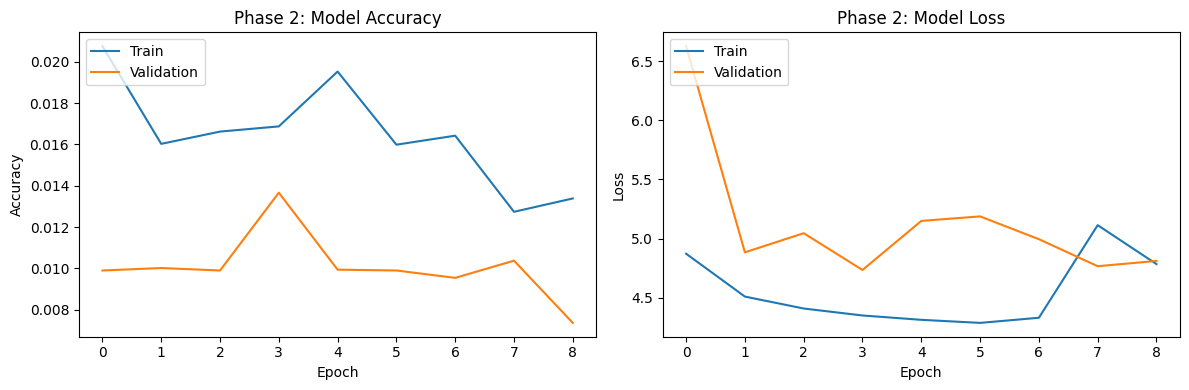

In [19]:
# Plot Phase 2 results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Phase 2: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Phase 2: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
# Save final model
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_path = f'../models/food101_model_{timestamp}.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to models/food101_model_20250317_2032.h5


: 

In [ ]:
# Convert to TensorFlow Lite for mobile deployment
print("\nConverting model to TensorFlow Lite...")

# Regular TFLite conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
tflite_path = f'../models/food101_model_{timestamp}.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)


Converting model to TensorFlow Lite...
INFO:tensorflow:Assets written to: /var/folders/ln/13_rf5392kz5pchj7wyd2nhm0000gn/T/tmpyky4selk/assets


INFO:tensorflow:Assets written to: /var/folders/ln/13_rf5392kz5pchj7wyd2nhm0000gn/T/tmpyky4selk/assets


In [ ]:
# Quantized TFLite conversion (smaller size)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TFLite model
quantized_path = f'../models/food101_model_quantized_{timestamp}.tflite'
with open(quantized_path, 'wb') as f:
    f.write(quantized_tflite_model)

print(f"Regular TFLite model size: {len(tflite_model) / (1024 * 1024):.2f} MB")
print(f"Quantized TFLite model size: {len(quantized_tflite_model) / (1024 * 1024):.2f} MB")


In [ ]:
# Test model on a few images
print("\nTesting model on sample images...")
for images, labels in test_dataset.take(1):
    # Get predictions
    predictions = model.predict(images)
    
    # Display results
    plt.figure(figsize=(15, 10))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        
        true_label = index_to_label[labels[i].numpy()]
        pred_idx = np.argmax(predictions[i])
        pred_label = index_to_label[pred_idx]
        confidence = predictions[i][pred_idx] * 100
        
        color = 'green' if true_label == pred_label else 'red'
        
        plt.title(f"True: {true_label.replace('_', ' ').title()}\n"
                  f"Pred: {pred_label.replace('_', ' ').title()}\n"
                  f"Conf: {confidence:.1f}%", 
                  color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to get top N predictions for a single image
def get_top_predictions(image_path, top_n=5):
    """Get top N predicted classes for a single image"""
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    
    # Get predictions
    preds = model.predict(img)[0]
    
    # Get top N classes
    top_indices = preds.argsort()[-top_n:][::-1]
    top_preds = [(index_to_label[idx], preds[idx] * 100) for idx in top_indices]
    
    return top_preds

In [ ]:
# Optional: Test on a custom image
if os.path.exists('test_image.jpg'):  # Replace with your test image path
    print("\nTesting on custom image...")
    test_img_path = 'test_image.jpg'
    top_preds = get_top_predictions(test_img_path)
    
    # Display image and predictions
    img = tf.io.read_file(test_img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE * 2, IMG_SIZE * 2])  # Larger for display
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Test Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(top_preds))
    plt.barh(y_pos, [pred[1] for pred in top_preds])
    plt.yticks(y_pos, [pred[0].replace('_', ' ').title() for pred in top_preds])
    plt.xlabel('Confidence (%)')
    plt.title('Top Predictions')
    plt.tight_layout()
    plt.show()

In [ ]:
# Function to look up nutrition information for a food
def get_nutrition(food_label):
    """Get nutrition information for a food label"""
    try:
        with open('food101_nutrition_database.json', 'r') as f:
            nutrition_db = json.load(f)
        
        if food_label in nutrition_db:
            return nutrition_db[food_label]
        else:
            return None
    except:
        print("Could not load nutrition database.")
        return None

In [ ]:
# Demonstrate how to get nutrition for a prediction
print("\nNutrition Information Example:")
sample_food = list(index_to_label.values())[0]  # Get first food label
nutrition = get_nutrition(sample_food)
if nutrition:
    print(f"Food: {sample_food.replace('_', ' ').title()}")
    print(f"Calories: {nutrition.get('calories', 'N/A')} kcal")
    print(f"Protein: {nutrition.get('protein', 'N/A')} g")
    print(f"Carbohydrates: {nutrition.get('carbohydrates', 'N/A')} g")
    print(f"Fat: {nutrition.get('fat', 'N/A')} g")
else:
    print(f"No nutrition information available for {sample_food}")

print("\nTraining and evaluation complete!")

In [ ]:
# Evaluate model performance on test dataset
print("\nFinal model evaluation on test dataset:")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")